# 0. Setup

In [1]:
# libraries

import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.regularizers import L2

# working directories
WORKDIR = os.path.abspath('D:\\Users\\nbakotic\\iccecme-dataset') # get the path of this file - image metadata
IMAGESDIR = os.path.join(WORKDIR, 'images') # get the path of image folder

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 1.1 - Load and Process Metadata

0. Load data.
1. Drop columns other than WindowCenter and WindowWidth. In this experiment, the goal is to see how well the model can predict these values from images alone. Another model will be built later to see impact of remaining features on predictions.
2. Some values for WindowCenter and WindowWidth contain more than one number. In those cases, the first value will be used for learning, like in "Using Autoencoders to Reduce Dimensionality of DICOM Metadata".
3. Convert string values to float32.

In [3]:
# 0. read metadata
metadata_df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')

# 1. drop columns that will not be used for the task
metadata_df = metadata_df.drop(columns=['Modality', 'Rows', 'Columns', 'BodyPartExamined', 'HighBit', 'StudyDescription'])

# 2. format numbers
# find cells that contain two instead of one number and return only the first number
def extract_number_from_list(val):
    if ',' in val:
        idx = val.find(',')
        return val[1:idx]
    else:
        return val
    
metadata_df = metadata_df.applymap(extract_number_from_list)

# 3. convert string values to float
metadata_df['WindowCenter'] = metadata_df['WindowCenter'].astype('float32')
metadata_df['WindowWidth'] = metadata_df['WindowWidth'].astype('float32')

# 1.2 Load and Process Images
0. Read images from folder. Because of .npy format, they are ready into a list and converted to ndarray.
1. Add padding to images so they are all the same size. Most images are around 512 x 512 px so those dimensions are used.
2. Some images contain values below 0, but as they show as black, they are converted to 0.
3. Grayscale images have one color channel, but this dimension is dropped by default in the array so it has to be added back.
4. Normalize the data. Since images range from 8-bit to 16-bit, the values are divided by 2^16 - 1.

In [4]:
# 0. loading images
# read an image with file_name from images directory
# images are already in numpy format
def read_file(file_name):
    imagepath = os.path.join(IMAGESDIR, f'{file_name}.npy')
    with open(imagepath, 'rb') as file:
        img = np.load(file)
    return img

# temporary image list to load files into
images_list = []
for i in range(len(metadata_df)):
    img = read_file(metadata_df.index[i])
    images_list.append(img)

#since images are loaded into a list, they will be converted into a numpy array
images = np.array(images_list, dtype=np.ndarray)

#free up the memory of images_list
del images_list


# 1. add padding to the images so they are all the same size
for i in range(len(images)):
    images[i] = pad_sequences(images[i], value=0,padding='post', maxlen=512)
    
images = pad_sequences(images, value=0,padding='post', maxlen=512)

# 2. negative values show as black, so they are converted to 0
images[images < 0] = 0

# 3. add color dimension into the array
images = np.expand_dims(images, -1)

# 4. normalize the data - images range from 8 bit to 16 bit
images = images / 65535

# 2. Create Datasets
Because the dataset is large, it is not possible to put all of it at once in the GPU memory. Creating a dataset using 'tf.data.Dataset.from_tensor_slices' is also not possible, therefore a custom DataGenerator class is used.

1. Create train-validation-test datasets.

In [5]:
# custom dataset generator class
from tensorflow.keras.utils import Sequence 
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = (self.y[0][idx * self.batch_size:(idx + 1) * self.batch_size], self.y[0][idx * self.batch_size:(idx + 1) * self.batch_size])
        return batch_x, batch_y
    
# format datasets - return tuple
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width

# 1. create train-validation-test dataset splits
# choose train, validation and test rations
train_ratio = 0.72
validation_ratio = 0.08
test_ratio = 0.20

# train - test split
x_train, x_test, y_train, y_test = train_test_split(images, metadata_df, test_size=1-train_ratio)

# test - validation split,validation is treated as train data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

# format outputs for each split
y_train = format_output(y_train)
y_val = format_output(y_val)
y_test = format_output(y_test)

In [6]:
BATCH_SIZE = 32

train_data = DataGenerator(x_train, np.array(y_train), BATCH_SIZE)
val_data = DataGenerator(x_val, np.array(y_val), BATCH_SIZE)
test_data = DataGenerator(x_test, np.array(y_test), BATCH_SIZE)

In [7]:
del images

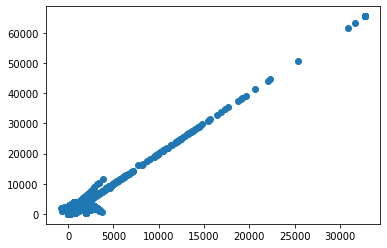

In [42]:
plt.scatter(np.array(metadata_df['WindowCenter']), np.array(metadata_df['WindowWidth']))

## Help Functions

In [11]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.show()


def plot_metrics(history, metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()
    
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# MULTI OUTPUT MODEL

In [31]:
def build_mo_model():
    inputs = Input(shape=(512, 512, 1))
    
    
    x = Conv2D(8, 3, kernel_regularizer=L2(0.01), activation='relu') (inputs)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(16, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    #####
    y = Conv2D(8, 3, kernel_regularizer=L2(0.01), activation='relu') (inputs)
    y = MaxPooling2D() (y)   
    
    y = Conv2D(16, 3, kernel_regularizer=L2(0.01), activation='relu') (y)
    y = MaxPooling2D() (y)
    
    y = Conv2D(16, 3, kernel_regularizer=L2(0.01), activation='relu') (y)
    y = MaxPooling2D() (y)
    
    y = Conv2D(32, 3, kernel_regularizer=L2(0.01), activation='relu') (y)
    y = MaxPooling2D() (y)
    
    y = Conv2D(32, 3, kernel_regularizer=L2(0.01), activation='relu') (y)
    y = MaxPooling2D() (y)
     
    y = Conv2D(64, 3, kernel_regularizer=L2(0.01), activation='relu') (y)
    y = MaxPooling2D() (y)
    
    y = Conv2D(64, 3, kernel_regularizer=L2(0.01), activation='relu') (y)
    y = MaxPooling2D() (y)
    
    
    
    x = Flatten() (x)
    y = Flatten() (y)
               
    x = Dense(units='64', activation='relu', kernel_regularizer=L2(0.01)) (x)
    y = Dense(units='64', activation='relu', kernel_regularizer=L2(0.01)) (y)     
               
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(y)
    
    model = Model(inputs=inputs, outputs=[output1, output2])
    
    return model

mo_model = build_mo_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.RootMeanSquaredError()
metric2 = tf.keras.metrics.RootMeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

optim = keras.optimizers.Adam()

mo_model.compile(optimizer=optim, loss=losses, metrics=metrics)

In [32]:
mo_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 510, 510, 8)  80          input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 510, 510, 8)  80          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_56 (MaxPooling2D) (None, 255, 255, 8)  0           conv2d_56[0][0]                  
____________________________________________________________________________________________

In [33]:
mo_history = mo_model.fit(train_data, epochs=100, validation_data=val_data, verbose=2)

Epoch 1/100
557/557 - 76s - loss: 2764444.5000 - window_center_loss: 1397887.8750 - window_width_loss: 1366553.6250 - window_center_root_mean_squared_error: 1182.3231 - window_width_root_mean_squared_error: 1168.9968 - val_loss: 1605920.3750 - val_window_center_loss: 839732.0000 - val_window_width_loss: 766182.9375 - val_window_center_root_mean_squared_error: 916.3689 - val_window_width_root_mean_squared_error: 875.3187
Epoch 2/100
557/557 - 76s - loss: 1631668.2500 - window_center_loss: 820256.8750 - window_width_loss: 811405.5000 - window_center_root_mean_squared_error: 905.6803 - window_width_root_mean_squared_error: 900.7805 - val_loss: 1055759.1250 - val_window_center_loss: 513153.2188 - val_window_width_loss: 542599.8125 - val_window_center_root_mean_squared_error: 716.3471 - val_window_width_root_mean_squared_error: 736.6137
Epoch 3/100
557/557 - 73s - loss: 1272269.6250 - window_center_loss: 605154.0000 - window_width_loss: 667108.6875 - window_center_root_mean_squared_error: 7

Epoch 21/100
557/557 - 60s - loss: 431861.8750 - window_center_loss: 216952.1094 - window_width_loss: 214887.9844 - window_center_root_mean_squared_error: 465.7812 - window_width_root_mean_squared_error: 463.5601 - val_loss: 352645.9688 - val_window_center_loss: 180453.1562 - val_window_width_loss: 172170.4688 - val_window_center_root_mean_squared_error: 424.7978 - val_window_width_root_mean_squared_error: 414.9343
Epoch 22/100
557/557 - 62s - loss: 426525.2500 - window_center_loss: 217003.2344 - window_width_loss: 209499.4062 - window_center_root_mean_squared_error: 465.8361 - window_width_root_mean_squared_error: 457.7110 - val_loss: 376177.3125 - val_window_center_loss: 138666.7188 - val_window_width_loss: 237487.6406 - val_window_center_root_mean_squared_error: 372.3798 - val_window_width_root_mean_squared_error: 487.3270
Epoch 23/100
557/557 - 61s - loss: 423027.2188 - window_center_loss: 194152.8438 - window_width_loss: 228851.1719 - window_center_root_mean_squared_error: 440.627

Epoch 41/100
557/557 - 56s - loss: 351420.3125 - window_center_loss: 154230.7344 - window_width_loss: 197149.2812 - window_center_root_mean_squared_error: 392.7222 - window_width_root_mean_squared_error: 444.0150 - val_loss: 248261.1406 - val_window_center_loss: 115882.8203 - val_window_width_loss: 132337.7656 - val_window_center_root_mean_squared_error: 340.4156 - val_window_width_root_mean_squared_error: 363.7826
Epoch 42/100
557/557 - 56s - loss: 353120.1875 - window_center_loss: 166260.0625 - window_width_loss: 186819.3125 - window_center_root_mean_squared_error: 407.7500 - window_width_root_mean_squared_error: 432.2260 - val_loss: 256961.9219 - val_window_center_loss: 125201.1719 - val_window_width_loss: 131719.4531 - val_window_center_root_mean_squared_error: 353.8378 - val_window_width_root_mean_squared_error: 362.9317
Epoch 43/100
557/557 - 56s - loss: 350859.0312 - window_center_loss: 175345.0625 - window_width_loss: 175472.0781 - window_center_root_mean_squared_error: 418.742

Epoch 61/100
557/557 - 57s - loss: 298619.5312 - window_center_loss: 154784.7344 - window_width_loss: 143777.0000 - window_center_root_mean_squared_error: 393.4269 - window_width_root_mean_squared_error: 379.1794 - val_loss: 224106.6562 - val_window_center_loss: 103488.2344 - val_window_width_loss: 120560.2656 - val_window_center_root_mean_squared_error: 321.6959 - val_window_width_root_mean_squared_error: 347.2179
Epoch 62/100
557/557 - 57s - loss: 288040.8750 - window_center_loss: 146116.2188 - window_width_loss: 141865.9844 - window_center_root_mean_squared_error: 382.2515 - window_width_root_mean_squared_error: 376.6510 - val_loss: 223253.5938 - val_window_center_loss: 104261.5000 - val_window_width_loss: 118933.0078 - val_window_center_root_mean_squared_error: 322.8955 - val_window_width_root_mean_squared_error: 344.8666
Epoch 63/100
557/557 - 56s - loss: 292117.1250 - window_center_loss: 158310.9844 - window_width_loss: 133746.7344 - window_center_root_mean_squared_error: 397.883

Epoch 81/100
557/557 - 58s - loss: 293491.9375 - window_center_loss: 142682.6250 - window_width_loss: 150734.5469 - window_center_root_mean_squared_error: 377.7336 - window_width_root_mean_squared_error: 388.2455 - val_loss: 201628.9219 - val_window_center_loss: 93614.1406 - val_window_width_loss: 107939.5000 - val_window_center_root_mean_squared_error: 305.9643 - val_window_width_root_mean_squared_error: 328.5415
Epoch 82/100
557/557 - 55s - loss: 350656.9062 - window_center_loss: 162093.5625 - window_width_loss: 188486.9531 - window_center_root_mean_squared_error: 402.6084 - window_width_root_mean_squared_error: 434.1508 - val_loss: 216850.5312 - val_window_center_loss: 93682.7500 - val_window_width_loss: 123091.3359 - val_window_center_root_mean_squared_error: 306.0764 - val_window_width_root_mean_squared_error: 350.8438
Epoch 83/100
557/557 - 55s - loss: 273045.2812 - window_center_loss: 131016.3438 - window_width_loss: 141952.2344 - window_center_root_mean_squared_error: 361.9618 

In [11]:
#mo_model = tf.keras.models.load_model('./mo_model1/')

In [34]:
# Run predict
Y_pred = mo_model.predict(test_data)
center_pred = Y_pred[0]
width_pred = Y_pred[1]

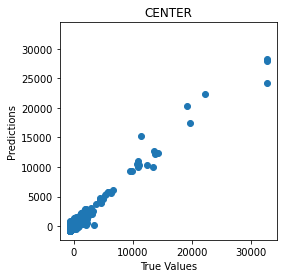

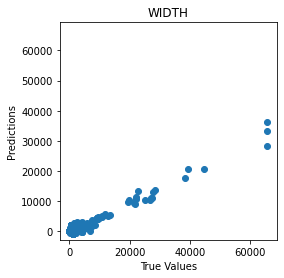

In [35]:
# Difference between true and predicted values
plot_diff(y_test[0], center_pred, title='CENTER')
plot_diff(y_test[1], width_pred, title='WIDTH')

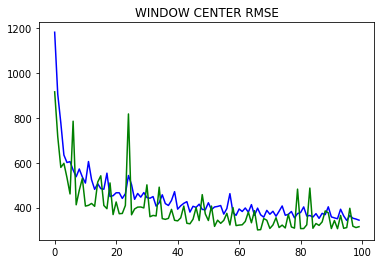

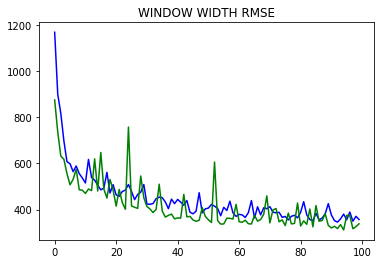

In [36]:
# Plot MSE
plot_metrics(mo_history, metric_name='window_center_root_mean_squared_error', title='WINDOW CENTER RMSE')
plot_metrics(mo_history, metric_name='window_width_root_mean_squared_error', title='WINDOW WIDTH RMSE')

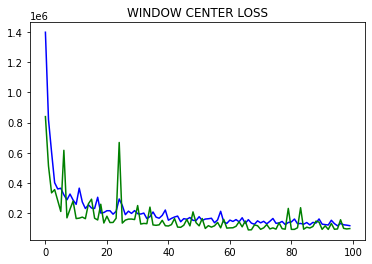

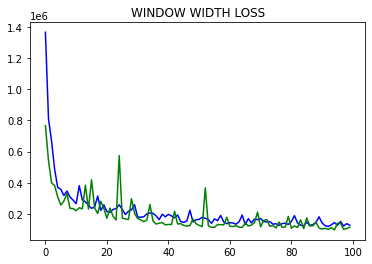

In [37]:
# Plot losses
plot_metrics(mo_history, metric_name='window_center_loss', title='WINDOW CENTER LOSS')
plot_metrics(mo_history, metric_name='window_width_loss', title='WINDOW WIDTH LOSS')

In [38]:
mo_predictions = pd.DataFrame({'Actual WindowCenter': y_test[0], 
                            'Predicted WindowCenter': center_pred.reshape(-1),
                            'WindowCenter Difference' : center_pred.reshape(-1) - y_test[0],
                            'Actual WindowWidth': y_test[1], 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) - y_test[1] })
mo_predictions

,Actual WindowCenter,Predicted WindowCenter,WindowCenter Difference,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,1840.0,1884.486084,44.486084,3190.0,1898.503418,-1291.496582
1,40.0,5.688467,-34.311531,300.0,37.123222,-262.876770
2,2048.0,2377.817383,329.817383,4096.0,2209.461670,-1886.538330
3,380.0,343.652222,-36.347778,438.0,376.901459,-61.098541
4,40.0,91.429344,51.429344,300.0,-8.081976,-308.081970
...,...,...,...,...,...,...
4940,195.0,231.161957,36.161957,488.0,220.500839,-267.499146
4941,2047.0,2642.943115,595.943115,4095.0,2014.334351,-2080.665527
4942,2700.0,2604.223389,-95.776611,2418.0,2613.079590,195.079590
4943,380.0,379.883057,-0.116943,438.0,388.520752,-49.479248


In [39]:
mo_score_center = r2_score(y_test[0], center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mo_score_center, 2) *100))
mo_score_width = r2_score(y_test[1], width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mo_score_width, 2) *100))

mo_mae_center =  mean_absolute_error(y_test[0], center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mo_mae_center, 2)))
mo_mae_width =  mean_absolute_error(y_test[1], width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mo_mae_width, 2)))

mo_mse_center = mean_squared_error(y_test[0], center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mo_mse_center, 2), round(np.sqrt(mo_mse_center), 2)))
mo_mse_width = mean_squared_error(y_test[1], width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mo_mse_width, 2), round(np.sqrt(mo_mse_width), 2)))

The accuracy of WindowCenter is 96.0%
The accuracy of WindowWidth is 62.0%
Mean absolute error of WindowCenter is 141.5
Mean absolute error of WindowWidth is 777.530029296875
Mean squared error of WindowCenter is 78948.390625, RMSE: 280.9800109863281
Mean squared errory of WindowWidth is 2567789.75, RMSE: 1602.4300537109375


In [40]:
#Save model
mo_model.save('./mo_model1/', save_format='tf')

INFO:tensorflow:Assets written to: ./mo_model1/assets


INFO:tensorflow:Assets written to: ./mo_model1/assets


# TEST - ONE OUTPUT, 2 MODELS IN SEQUENCE

## CENTER ONLY MODEL

In [18]:
# custom dataset generator class
from tensorflow.keras.utils import Sequence 
class DataGeneratorArray(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [44]:
BATCH_SIZE = 32

train_data = DataGeneratorArray(x_train, np.array(y_train[0]), BATCH_SIZE)
val_data = DataGeneratorArray(x_val, np.array(y_val[0]), BATCH_SIZE)
test_data = DataGeneratorArray(x_test, np.array(y_test[0]), BATCH_SIZE)

In [45]:
def build_model_center():
    inputs = Input(shape=(512, 512, 1))
    x = Conv2D(8, 3, kernel_regularizer=L2(0.01), activation='relu') (inputs)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(16, 3,kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, 3,kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3,kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3,kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)  
    
    x = Conv2D(64, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    

    x = Flatten() (x)
    x = Dense(units='64', activation='relu', kernel_regularizer=L2(0.01)) (x)
    
    output = Dense(units='1', activation='linear', name="window_center")(x)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model

model_center = build_model_center()

model_center.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [46]:
model_center.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 510, 510, 8)       80        
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 255, 255, 8)       0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 253, 253, 16)      1168      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 62, 62, 16)        0   

In [47]:
history_center = model_center.fit(train_data, epochs=100, validation_data=val_data, verbose=2)

Epoch 1/100
557/557 - 36s - loss: 1477093.5000 - root_mean_squared_error: 1215.3566 - val_loss: 805004.5000 - val_root_mean_squared_error: 897.2192
Epoch 2/100
557/557 - 33s - loss: 835763.5000 - root_mean_squared_error: 914.1996 - val_loss: 716164.8750 - val_root_mean_squared_error: 846.2637
Epoch 3/100
557/557 - 34s - loss: 737964.1250 - root_mean_squared_error: 859.0469 - val_loss: 648377.1875 - val_root_mean_squared_error: 805.2168
Epoch 4/100
557/557 - 34s - loss: 559636.5000 - root_mean_squared_error: 748.0864 - val_loss: 339168.2812 - val_root_mean_squared_error: 582.3784
Epoch 5/100
557/557 - 34s - loss: 439107.2188 - root_mean_squared_error: 662.6486 - val_loss: 258299.1719 - val_root_mean_squared_error: 508.2273
Epoch 6/100
557/557 - 35s - loss: 359972.7188 - root_mean_squared_error: 599.9734 - val_loss: 228225.8906 - val_root_mean_squared_error: 477.7250
Epoch 7/100
557/557 - 34s - loss: 330772.7500 - root_mean_squared_error: 575.1239 - val_loss: 213194.1250 - val_root_mean_

Epoch 57/100
557/557 - 32s - loss: 143533.1250 - root_mean_squared_error: 378.8249 - val_loss: 145011.0156 - val_root_mean_squared_error: 380.7705
Epoch 58/100
557/557 - 32s - loss: 201728.0781 - root_mean_squared_error: 449.1138 - val_loss: 119904.7109 - val_root_mean_squared_error: 346.2364
Epoch 59/100
557/557 - 32s - loss: 138484.9688 - root_mean_squared_error: 372.1017 - val_loss: 113452.2344 - val_root_mean_squared_error: 336.7888
Epoch 60/100
557/557 - 32s - loss: 229090.7188 - root_mean_squared_error: 478.6072 - val_loss: 97493.3125 - val_root_mean_squared_error: 312.1976
Epoch 61/100
557/557 - 32s - loss: 136234.6719 - root_mean_squared_error: 369.0645 - val_loss: 101835.2266 - val_root_mean_squared_error: 319.0753
Epoch 62/100
557/557 - 32s - loss: 130097.2266 - root_mean_squared_error: 360.6535 - val_loss: 96791.3906 - val_root_mean_squared_error: 311.0705
Epoch 63/100
557/557 - 32s - loss: 137049.2969 - root_mean_squared_error: 370.1658 - val_loss: 107902.0547 - val_root_me

In [37]:
#model_center = tf.keras.models.load_model('./model_centeronly1/')

In [48]:
Y_pred = model_center.predict(test_data)
center_pred = Y_pred

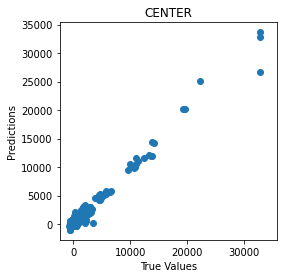

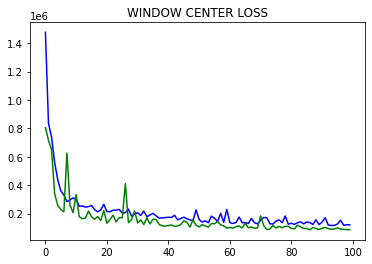

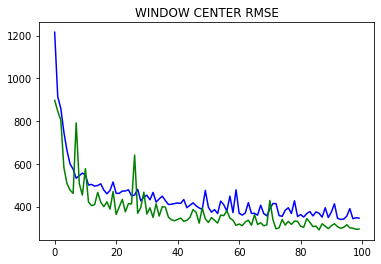

,Actual WindowCenter,Predicted WindowCenter,WindowCenter Difference
0,1840.0,1681.761353,-158.238647
1,40.0,209.140640,169.140640
2,2048.0,2360.936279,312.936279
3,380.0,326.471893,-53.528107
4,40.0,-88.018875,-128.018875
...,...,...,...
4940,195.0,292.436005,97.436005
4941,2047.0,2555.827881,508.827881
4942,2700.0,2376.331055,-323.668945
4943,380.0,388.805939,8.805939


In [49]:
# Plot difference
plot_diff(y_test[0], center_pred, title='CENTER')
# Plot loss
plot_metrics(history_center,metric_name='loss', title='WINDOW CENTER LOSS')
# Plot RMSE
plot_metrics(history_center,metric_name='root_mean_squared_error', title='WINDOW CENTER RMSE')

predictions_center = pd.DataFrame({'Actual WindowCenter': y_test[0], 
                            'Predicted WindowCenter': center_pred.reshape(-1),
                            'WindowCenter Difference' : center_pred.reshape(-1) - y_test[0]})
predictions_center

In [50]:
score_center = r2_score(y_test[0], center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(score_center, 2) *100))

mae_center =  mean_absolute_error(y_test[0], center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mae_center, 2)))

mse_center = mean_squared_error(y_test[0], center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mse_center, 2), round(np.sqrt(mse_center), 2)))

The accuracy of WindowCenter is 97.0%
Mean absolute error of WindowCenter is 135.8300018310547
Mean squared error of WindowCenter is 56537.8984375, RMSE: 237.77999877929688


In [51]:
predictions_center.loc[predictions_center['WindowCenter Difference'] == predictions_center['WindowCenter Difference'].max()]

,Actual WindowCenter,Predicted WindowCenter,WindowCenter Difference
250,22317.0,25019.066406,2702.066406


In [53]:
model_center.save('./model_centeronly1/', save_format='tf')

INFO:tensorflow:Assets written to: ./model_centeronly1/assets


INFO:tensorflow:Assets written to: ./model_centeronly1/assets


## WIDTH PREDICTION MODELS

### 1. Image + WindowCenter

In [6]:
### IMAGE + WINDOWCENTER MODEL 
def build_model_imgcenter():
    input_image = Input(shape=(512, 512, 1))
    x = Conv2D(8, 3, activation='relu') (input_image)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(16, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, kernel_regularizer=L2(0.01),activation='relu') (x)
    x = MaxPooling2D() (x)  
    
    x = Conv2D(64, 3, 1, kernel_regularizer=L2(0.01),activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, 1,kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
      
    x = Flatten() (x)
    
    
    input_center = Input(shape=(1))
    y = Dense(8, activation="relu") (input_center)
    y = Dense(32, activation="relu") (y)
    y = Dense(32, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(128, activation="relu") (y)
    y= tf.keras.layers.Reshape((128,))(y)
    
    
    
    combined = tf.keras.layers.concatenate([x, y])
    combined = Dense(units='64', activation='relu', kernel_regularizer=L2(0.01)) (combined)
    output = Dense(units='1', activation='linear', name="window_width")(combined)
    model = Model(inputs=[input_image, input_center], outputs=output)
        
    #output = Dense(units='1', activation='linear', name="window_width")(y)
    #model = Model(inputs=input_center, outputs=output)
    
    return model

model_imgcenter = build_model_imgcenter()

model_imgcenter.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [7]:
model_imgcenter.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 510, 510, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 255, 255, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 253, 253, 16) 1168        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [8]:
history_imgcenter = model_imgcenter.fit(x=[x_train[:2000],y_train[0][:2000]/65535], y=y_train[1][:2000], 
                      epochs=100, validation_data=([x_val[:400], y_val[0][:400]/65535], y_val[1][:400]), verbose=2)

Epoch 1/100
63/63 - 194s - loss: 5545464.5000 - root_mean_squared_error: 2354.8806 - val_loss: 6502597.0000 - val_root_mean_squared_error: 2550.0186
Epoch 2/100
63/63 - 5s - loss: 4271796.0000 - root_mean_squared_error: 2066.8320 - val_loss: 6101211.0000 - val_root_mean_squared_error: 2470.0627
Epoch 3/100
63/63 - 4s - loss: 4193982.0000 - root_mean_squared_error: 2047.9209 - val_loss: 6067323.0000 - val_root_mean_squared_error: 2463.1931
Epoch 4/100
63/63 - 4s - loss: 4146458.5000 - root_mean_squared_error: 2036.2849 - val_loss: 6034973.0000 - val_root_mean_squared_error: 2456.6179
Epoch 5/100
63/63 - 4s - loss: 4138558.0000 - root_mean_squared_error: 2034.3444 - val_loss: 5948385.5000 - val_root_mean_squared_error: 2438.9307
Epoch 6/100
63/63 - 5s - loss: 4106095.7500 - root_mean_squared_error: 2026.3499 - val_loss: 5944183.5000 - val_root_mean_squared_error: 2438.0691
Epoch 7/100
63/63 - 4s - loss: 3979218.0000 - root_mean_squared_error: 1994.7970 - val_loss: 5192178.0000 - val_root

Epoch 58/100
63/63 - 4s - loss: 202638.6562 - root_mean_squared_error: 450.1452 - val_loss: 258741.5000 - val_root_mean_squared_error: 508.6585
Epoch 59/100
63/63 - 4s - loss: 181981.1562 - root_mean_squared_error: 426.5830 - val_loss: 306671.2812 - val_root_mean_squared_error: 553.7718
Epoch 60/100
63/63 - 4s - loss: 176223.9219 - root_mean_squared_error: 419.7806 - val_loss: 261604.3438 - val_root_mean_squared_error: 511.4647
Epoch 61/100
63/63 - 4s - loss: 196017.5000 - root_mean_squared_error: 442.7293 - val_loss: 294235.2812 - val_root_mean_squared_error: 542.4270
Epoch 62/100
63/63 - 4s - loss: 174526.5312 - root_mean_squared_error: 417.7538 - val_loss: 265904.6250 - val_root_mean_squared_error: 515.6514
Epoch 63/100
63/63 - 5s - loss: 178878.6250 - root_mean_squared_error: 422.9305 - val_loss: 302966.6562 - val_root_mean_squared_error: 550.4165
Epoch 64/100
63/63 - 4s - loss: 179855.8438 - root_mean_squared_error: 424.0841 - val_loss: 254880.7188 - val_root_mean_squared_error: 5

In [9]:
width_pred = model_imgcenter.predict([x_test[:1000], y_test[0][:1000]/65535])

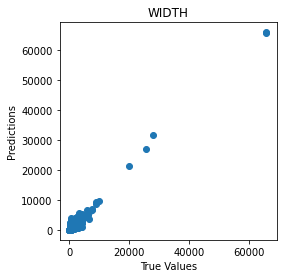

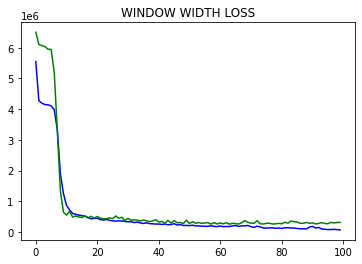

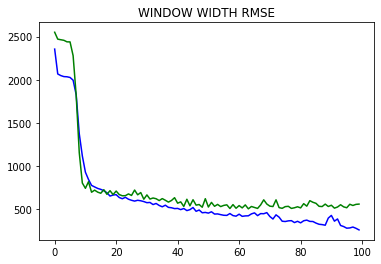

In [12]:
# Plot difference
plot_diff(y_test[1][:1000], width_pred, title='WIDTH')
# Plot loss
plot_metrics(history_imgcenter, metric_name='loss', title='WINDOW WIDTH LOSS')
# Plot RMSE
plot_metrics(history_imgcenter, metric_name='root_mean_squared_error', title='WINDOW WIDTH RMSE')

predictions_imgcenter = pd.DataFrame({'Actual WindowWidth':  y_test[1][:1000], 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) -  y_test[1][:1000]})

In [13]:
predictions_imgcenter

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,2152.0,4080.803711,1928.803711
1,488.0,500.362183,12.362183
2,657.0,670.690247,13.690247
3,400.0,424.477997,24.477997
4,4095.0,3367.563232,-727.436768
...,...,...,...
995,438.0,697.426575,259.426575
996,3370.0,3130.911865,-239.088135
997,305.0,577.996216,272.996216
998,555.0,486.035431,-68.964569


In [14]:
score_imgcenter = r2_score( y_test[1][:1000], width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(score_imgcenter, 2) *100))

mae_imgcenter =  mean_absolute_error(y_test[1][:1000], width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mae_imgcenter, 2)))

mse_imgcenter = mean_squared_error(y_test[1][:1000], width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mse_imgcenter, 2), round(np.sqrt(mse_imgcenter), 2)))

The accuracy of WindowWidth is 97.0%
Mean absolute error of WindowWidth is 341.95001220703125
Mean squared error of WindowWidth is 352315.96875, RMSE: 593.5599975585938


In [15]:
predictions_imgcenter.loc[predictions_imgcenter['WindowWidth Difference'] == predictions_imgcenter['WindowWidth Difference'].min()]

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
72,4096.0,1198.053101,-2897.946777


In [16]:
model_imgcenter.save('./model_width_imgcenter1/', save_format='tf')

INFO:tensorflow:Assets written to: ./model_width_imgcenter1/assets


### 2. Image Only

In [19]:
BATCH_SIZE = 32

train_data = DataGeneratorArray(x_train, np.array(y_train[1]), BATCH_SIZE)
val_data = DataGeneratorArray(x_val, np.array(y_val[1]), BATCH_SIZE)
test_data = DataGeneratorArray(x_test, np.array(y_test[1]), BATCH_SIZE)

In [21]:
def build_model_imgonly():
    inputs = Input(shape=(512, 512, 1))
    x = Conv2D(8, 3, kernel_regularizer=L2(0.01), activation='relu') (inputs)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(16, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)  
    
    x = Conv2D(64, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, kernel_regularizer=L2(0.01), activation='relu') (x)
    x = MaxPooling2D() (x)
      
    

    x = Flatten() (x)
    x = Dense(units='64', activation='relu', kernel_regularizer=L2(0.01)) (x)
    output = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model

model_imgonly = build_model_imgonly()

model_imgonly.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [22]:
model_imgonly.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 510, 510, 8)       80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 255, 255, 8)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 253, 253, 16)      1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 16)        0   

In [23]:
history_imgonly = model_imgonly.fit(train_data, epochs=100, validation_data=val_data, verbose=2)

Epoch 1/100
557/557 - 69s - loss: 4713941.5000 - root_mean_squared_error: 2171.1602 - val_loss: 5491312.0000 - val_root_mean_squared_error: 2343.3545
Epoch 2/100
557/557 - 34s - loss: 2031565.8750 - root_mean_squared_error: 1425.3290 - val_loss: 3122189.2500 - val_root_mean_squared_error: 1766.9706
Epoch 3/100
557/557 - 39s - loss: 1562250.7500 - root_mean_squared_error: 1249.8986 - val_loss: 2062843.5000 - val_root_mean_squared_error: 1436.2588
Epoch 4/100
557/557 - 40s - loss: 1014496.5000 - root_mean_squared_error: 1007.2200 - val_loss: 1194348.6250 - val_root_mean_squared_error: 1092.8604
Epoch 5/100
557/557 - 37s - loss: 864003.2500 - root_mean_squared_error: 929.5150 - val_loss: 1081404.1250 - val_root_mean_squared_error: 1039.9033
Epoch 6/100
557/557 - 34s - loss: 993794.8750 - root_mean_squared_error: 996.8901 - val_loss: 1703198.8750 - val_root_mean_squared_error: 1305.0646
Epoch 7/100
557/557 - 33s - loss: 746817.7500 - root_mean_squared_error: 864.1828 - val_loss: 780410.000

Epoch 57/100
557/557 - 31s - loss: 320550.7188 - root_mean_squared_error: 566.1512 - val_loss: 598720.7500 - val_root_mean_squared_error: 773.7552
Epoch 58/100
557/557 - 32s - loss: 353886.3125 - root_mean_squared_error: 594.8634 - val_loss: 497173.1250 - val_root_mean_squared_error: 705.0881
Epoch 59/100
557/557 - 32s - loss: 323058.1562 - root_mean_squared_error: 568.3609 - val_loss: 492768.3125 - val_root_mean_squared_error: 701.9571
Epoch 60/100
557/557 - 31s - loss: 358337.1250 - root_mean_squared_error: 598.5923 - val_loss: 874564.7500 - val_root_mean_squared_error: 935.1684
Epoch 61/100
557/557 - 32s - loss: 404317.6875 - root_mean_squared_error: 635.8400 - val_loss: 547327.3750 - val_root_mean_squared_error: 739.7986
Epoch 62/100
557/557 - 32s - loss: 480173.1875 - root_mean_squared_error: 692.9266 - val_loss: 494947.3125 - val_root_mean_squared_error: 703.5066
Epoch 63/100
557/557 - 31s - loss: 313676.9062 - root_mean_squared_error: 560.0454 - val_loss: 436207.2188 - val_root_

In [24]:
width_pred = model_imgonly.predict(test_data) 

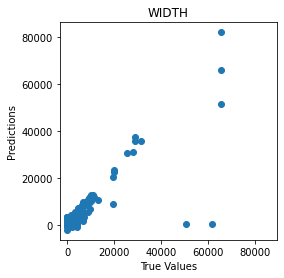

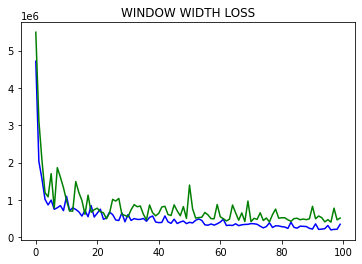

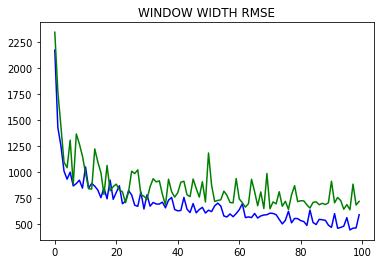

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,2152.0,1870.148926,-281.851074
1,488.0,401.089905,-86.910095
2,657.0,406.881226,-250.118774
3,400.0,365.633514,-34.366486
4,4095.0,3444.813477,-650.186523
...,...,...,...
4940,432.0,405.764587,-26.235413
4941,3494.0,2670.083984,-823.916016
4942,400.0,835.095886,435.095886
4943,2060.0,1663.825195,-396.174805


In [25]:
# Plot difference
plot_diff(y_test[1], width_pred, title='WIDTH')
# Plot loss
plot_metrics(history_imgonly, metric_name='loss', title='WINDOW WIDTH LOSS')
# Plot RMSE
plot_metrics(history_imgonly, metric_name='root_mean_squared_error', title='WINDOW WIDTH RMSE')

predictions_imgonly = pd.DataFrame({'Actual WindowWidth': y_test[1], 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) - y_test[1]})
predictions_imgonly

In [26]:
score_imgonly = r2_score(y_test[1], width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(score_imgonly, 2) *100))

mae_imgonly =  mean_absolute_error(y_test[1], width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mae_imgonly, 2)))

mse_imgonly = mean_squared_error(y_test[1], width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mse_imgonly, 2), round(np.sqrt(mse_imgonly), 2)))

The accuracy of WindowWidth is 72.0%
Mean absolute error of WindowWidth is 446.45001220703125
Mean squared error of WindowWidth is 1852292.125, RMSE: 1360.989990234375


In [27]:
predictions_imgonly.loc[predictions_imgonly['WindowWidth Difference'] == predictions_imgonly['WindowWidth Difference'].min()]

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
1973,61676.0,286.761139,-61389.238281


In [52]:
model_imgonly.save('./model_width_imgonly1/', save_format='tf')

INFO:tensorflow:Assets written to: ./model_width_imgonly1/assets


### 3. WindowCenter Only

In [29]:
def build_model_centeronly():    
    input_center = Input(shape=(1))
    y = Dense(8, activation="relu") (input_center)
    y = Dense(32, activation="relu") (y)
    y = Dense(32, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(128, activation="relu") (y)
    y = Dense(units='64', activation='relu', kernel_regularizer=L2(0.01)) (y)
    output = Dense(units='1', activation='linear', name="window_width")(y)
    model = Model(inputs=input_center, outputs=output)
    
    return model

model_centeronly = build_model_centeronly()

model_centeronly.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [30]:
model_centeronly.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_15 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320

In [31]:
history_centeronly = model_centeronly.fit(y_train[0]/65535,y_train[1], epochs=100, validation_data=(y_val[0]/65535, y_val[1]), verbose=2)

Epoch 1/100
557/557 - 6s - loss: 5420438.5000 - root_mean_squared_error: 2328.1836 - val_loss: 1320079.7500 - val_root_mean_squared_error: 1148.9468
Epoch 2/100
557/557 - 5s - loss: 635165.0000 - root_mean_squared_error: 796.9719 - val_loss: 600157.4375 - val_root_mean_squared_error: 774.6973
Epoch 3/100
557/557 - 5s - loss: 514993.9688 - root_mean_squared_error: 717.6296 - val_loss: 553244.1250 - val_root_mean_squared_error: 743.8023
Epoch 4/100
557/557 - 5s - loss: 493330.5938 - root_mean_squared_error: 702.3729 - val_loss: 468470.5938 - val_root_mean_squared_error: 684.4452
Epoch 5/100
557/557 - 5s - loss: 459397.5625 - root_mean_squared_error: 677.7837 - val_loss: 441572.7812 - val_root_mean_squared_error: 664.5037
Epoch 6/100
557/557 - 5s - loss: 450188.0938 - root_mean_squared_error: 670.9547 - val_loss: 486961.8438 - val_root_mean_squared_error: 697.8207
Epoch 7/100
557/557 - 5s - loss: 437335.5000 - root_mean_squared_error: 661.3069 - val_loss: 429366.4375 - val_root_mean_squar

Epoch 58/100
557/557 - 5s - loss: 357594.8125 - root_mean_squared_error: 597.9828 - val_loss: 360359.3438 - val_root_mean_squared_error: 600.2904
Epoch 59/100
557/557 - 5s - loss: 367166.5000 - root_mean_squared_error: 605.9339 - val_loss: 394738.1562 - val_root_mean_squared_error: 628.2732
Epoch 60/100
557/557 - 5s - loss: 358722.3125 - root_mean_squared_error: 598.9253 - val_loss: 438659.6875 - val_root_mean_squared_error: 662.3055
Epoch 61/100
557/557 - 5s - loss: 386635.0000 - root_mean_squared_error: 621.7906 - val_loss: 385204.2812 - val_root_mean_squared_error: 620.6391
Epoch 62/100
557/557 - 5s - loss: 357827.0938 - root_mean_squared_error: 598.1768 - val_loss: 433458.3125 - val_root_mean_squared_error: 658.3669
Epoch 63/100
557/557 - 5s - loss: 342458.9062 - root_mean_squared_error: 585.1899 - val_loss: 388130.6875 - val_root_mean_squared_error: 622.9921
Epoch 64/100
557/557 - 5s - loss: 351406.8125 - root_mean_squared_error: 592.7861 - val_loss: 348808.3125 - val_root_mean_sq

In [32]:
width_pred = model_centeronly.predict(y_test[0]/65535) 

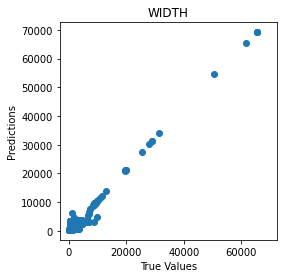

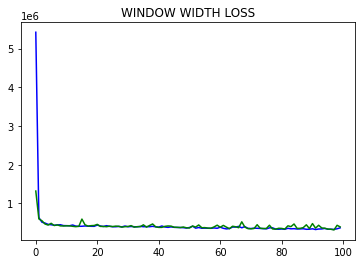

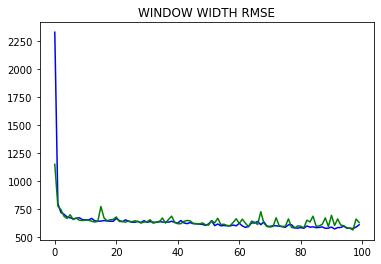

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,2152.0,2441.930420,289.930420
1,488.0,716.403931,228.403931
2,657.0,637.559570,-19.440430
3,400.0,471.715118,71.715118
4,4095.0,3702.642090,-392.357910
...,...,...,...
4940,432.0,520.653137,88.653137
4941,3494.0,3349.499512,-144.500488
4942,400.0,308.291199,-91.708801
4943,2060.0,2576.180176,516.180176


In [33]:
# Plot difference
plot_diff(y_test[1], width_pred, title='WIDTH')
# Plot loss
plot_metrics(history_centeronly, metric_name='loss', title='WINDOW WIDTH LOSS')
# Plot RMSE
plot_metrics(history_centeronly, metric_name='root_mean_squared_error', title='WINDOW WIDTH RMSE')

predictions_centeronly = pd.DataFrame({'Actual WindowWidth': y_test[1], 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) - y_test[1]})
predictions_centeronly

In [34]:
score_centeronly = r2_score(y_test[1], width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(score_centeronly, 2) *100))

mae_centeronly =  mean_absolute_error(y_test[1], width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mae_centeronly, 2)))

mse_centeronly = mean_squared_error(y_test[1], width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mse_centeronly, 2), round(np.sqrt(mse_centeronly), 2)))

The accuracy of WindowWidth is 94.0%
Mean absolute error of WindowWidth is 390.0799865722656
Mean squared error of WindowWidth is 386860.375, RMSE: 621.97998046875


In [35]:
model_centeronly.save('./model_width_centeronly1/', save_format='tf')

INFO:tensorflow:Assets written to: ./model_width_centeronly1/assets


## idea - Check "compouded error" for having a model predict WindowCenter and use those predictions to feed the next model in line

In [39]:
width_pred = model_centeronly.predict(center_pred/65535) 

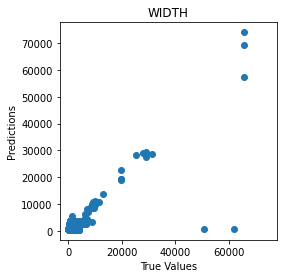

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,2152.0,962.006470,-1189.993530
1,488.0,787.884094,299.884094
2,657.0,583.245239,-73.754761
3,400.0,514.220337,114.220337
4,4095.0,3539.083252,-555.916748
...,...,...,...
4940,432.0,536.898071,104.898071
4941,3494.0,3344.932129,-149.067871
4942,400.0,348.947449,-51.052551
4943,2060.0,2934.567627,874.567627


In [40]:
# Plot difference
plot_diff(y_test[1], width_pred, title='WIDTH')
predictions_compound = pd.DataFrame({'Actual WindowWidth': y_test[1], 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) - y_test[1]})
predictions_compound

In [41]:
score_centeronly = r2_score(y_test[1], width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(score_centeronly, 2) *100))

mae_centeronly =  mean_absolute_error(y_test[1], width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mae_centeronly, 2)))

mse_centeronly = mean_squared_error(y_test[1], width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mse_centeronly, 2), round(np.sqrt(mse_centeronly), 2)))

The accuracy of WindowWidth is 73.0%
Mean absolute error of WindowWidth is 483.4100036621094
Mean squared error of WindowWidth is 1792096.75, RMSE: 1338.68994140625


# IMPACT OF MODALITY, BODY PART EXAMINED AND HIGHBIT ON RESULTS

In [64]:
# 0. read metadata
df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
df = df.drop(columns=['WindowCenter' ,'WindowWidth', 'Rows', 'Columns', 'StudyDescription'])
df = df.fillna(value='UNKNOWN')
mod_dummies = pd.get_dummies(df.Modality)
bpe_dummies = pd.get_dummies(df.BodyPartExamined)
df = pd.concat([df,mod_dummies, bpe_dummies], axis='columns')
df = df.drop(columns=['Modality' ,'BodyPartExamined', 'XA','UNKNOWN'])

In [65]:
df

,HighBit,CR,CT,MR,NM,RF,ABDOM,ABDOMEN,ANKLE,BREAST,...,L_SPNE,NECK,PELVIS,SHOULDER,SKULL,SPINE,TEST,THORAX,TSPINE,UP_EXM
id,,,,,,,,,,,,,,,,,,,,,
2460558,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2854204,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2905685,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2928440,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2928448,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30762622,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30777208,11,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30782601,11,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


TO DO - create train test splits with different set of labels, then distribute them into different arrays. Make a multiple input model with images and helper labels. Use the best configuration of the above models. 

In [66]:
df = pd.concat([metadata_df, df], axis='columns')

In [67]:
df

,WindowCenter,WindowWidth,HighBit,CR,CT,MR,NM,RF,ABDOM,ABDOMEN,...,L_SPNE,NECK,PELVIS,SHOULDER,SKULL,SPINE,TEST,THORAX,TSPINE,UP_EXM
id,,,,,,,,,,,,,,,,,,,,,
2460558,1905.0,2300.0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2854204,2048.0,4096.0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2905685,115.0,109.0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2928440,2048.0,4096.0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2928448,2048.0,4096.0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30762622,1256.0,2527.0,11,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30777208,-600.0,1200.0,11,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30782601,35.0,80.0,11,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
np.array(df).shape

(24719, 35)

In [73]:
# custom dataset generator class
from tensorflow.keras.utils import Sequence 
class DataGeneratorArray(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

    
# format datasets - return tuple
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width


# 1. create train-validation-test dataset splits
# choose train, validation and test rations
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train - test split
x_train_img, x_test_img, x_train_meta, x_test_meta = train_test_split(images, df, test_size=1-train_ratio)

# test - validation split,validation is treated as train data
x_val_img, x_test_img, x_val_meta, x_test_meta = train_test_split(x_test_img, x_test_meta, test_size=test_ratio/(test_ratio + validation_ratio))

In [74]:
y_train = format_output(x_train_meta)
y_val = format_output(x_val_meta)
y_test = format_output(x_test_meta)

In [75]:
x_train_meta = np.array(x_train_meta)
x_val_meta = np.array(x_val_meta)
x_test_meta = np.array(x_test_meta)

In [76]:
del images

## WindowCenter Predictions With Help of Metadata

In [70]:
### IMAGE + METADATA MODEL 
def build_model_imgmeta():
    input_image = Input(shape=(512, 512, 1))
    x = Conv2D(8, 3, activation='relu') (input_image)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(16, 3, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, 3, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, activation='relu') (x)
    x = MaxPooling2D() (x)  
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    x = MaxPooling2D() (x)
      
    x = Flatten() (x)
    
    
    input_meta = Input(shape=(33))
    y = Dense(8, activation="relu") (input_meta)
    y = Dense(32, activation="relu") (y)
    y = Dense(32, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(128, activation="relu") (y)
    y= tf.keras.layers.Reshape((128,))(y)
    
    
    
    combined = tf.keras.layers.concatenate([x, y])
    output = Dense(units='1', activation='linear', name="window_center")(combined)
    model = Model(inputs=[input_image, input_meta], outputs=output)
    
    return model

model_imgmeta = build_model_imgmeta()

model_imgmeta.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [71]:
model_imgmeta.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 510, 510, 8)  80          input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 255, 255, 8)  0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 253, 253, 16) 1168        max_pooling2d_32[0][0]           
____________________________________________________________________________________________

In [77]:
history_imgmeta = model_imgmeta.fit(x=[x_train_img[:2000],x_train_meta[:2000]], y=y_train[0][:2000], 
                      epochs=100, validation_data=([x_val_img[:400], x_val_meta[:400]], y_val[0][:400]), verbose=2)

Epoch 1/100
63/63 - 15s - loss: 1882192.6250 - root_mean_squared_error: 1371.9303 - val_loss: 2029723.8750 - val_root_mean_squared_error: 1424.6838
Epoch 2/100
63/63 - 4s - loss: 1426533.3750 - root_mean_squared_error: 1194.3757 - val_loss: 1947261.2500 - val_root_mean_squared_error: 1395.4430
Epoch 3/100
63/63 - 4s - loss: 1383115.1250 - root_mean_squared_error: 1176.0591 - val_loss: 1885166.1250 - val_root_mean_squared_error: 1373.0134
Epoch 4/100
63/63 - 4s - loss: 1349857.5000 - root_mean_squared_error: 1161.8336 - val_loss: 1908017.8750 - val_root_mean_squared_error: 1381.3102
Epoch 5/100
63/63 - 4s - loss: 1296831.7500 - root_mean_squared_error: 1138.7852 - val_loss: 1729336.5000 - val_root_mean_squared_error: 1315.0424
Epoch 6/100
63/63 - 4s - loss: 1234137.1250 - root_mean_squared_error: 1110.9172 - val_loss: 1689389.5000 - val_root_mean_squared_error: 1299.7651
Epoch 7/100
63/63 - 4s - loss: 1175637.3750 - root_mean_squared_error: 1084.2681 - val_loss: 1388097.5000 - val_root_

Epoch 58/100
63/63 - 4s - loss: 374295.2188 - root_mean_squared_error: 611.7967 - val_loss: 355585.6875 - val_root_mean_squared_error: 596.3101
Epoch 59/100
63/63 - 4s - loss: 366359.2500 - root_mean_squared_error: 605.2762 - val_loss: 349730.9062 - val_root_mean_squared_error: 591.3805
Epoch 60/100
63/63 - 4s - loss: 363956.8438 - root_mean_squared_error: 603.2883 - val_loss: 343227.4062 - val_root_mean_squared_error: 585.8561
Epoch 61/100
63/63 - 4s - loss: 365087.2500 - root_mean_squared_error: 604.2245 - val_loss: 411084.5312 - val_root_mean_squared_error: 641.1588
Epoch 62/100
63/63 - 4s - loss: 421290.7812 - root_mean_squared_error: 649.0692 - val_loss: 389145.1875 - val_root_mean_squared_error: 623.8150
Epoch 63/100
63/63 - 4s - loss: 447734.2500 - root_mean_squared_error: 669.1295 - val_loss: 928561.8125 - val_root_mean_squared_error: 963.6191
Epoch 64/100
63/63 - 4s - loss: 583673.8125 - root_mean_squared_error: 763.9855 - val_loss: 519542.8438 - val_root_mean_squared_error: 7

In [78]:
center_pred = model_imgmeta.predict([x_test_img[:1000], x_test_meta[:1000]])

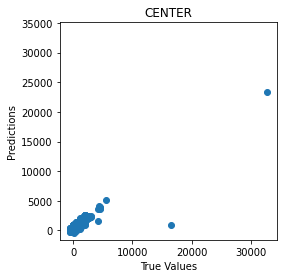

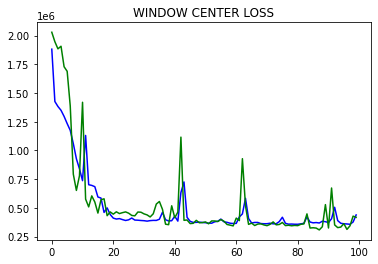

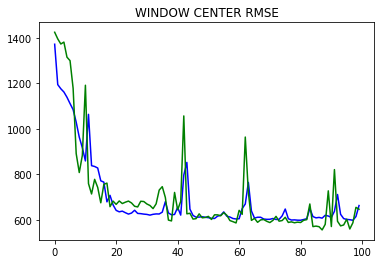

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,60.0,171.383377,111.383377
1,216.0,320.866180,104.866180
2,1776.0,2022.397583,246.397583
3,360.0,419.892212,59.892212
4,280.0,548.782471,268.782471
...,...,...,...
995,157.0,187.681503,30.681503
996,2047.0,2125.639404,78.639404
997,40.0,-59.887520,-99.887520
998,551.0,873.868713,322.868713


In [79]:
# Plot difference
plot_diff(y_test[0][:1000], center_pred, title='CENTER')
# Plot loss
plot_metrics(history_imgmeta, metric_name='loss', title='WINDOW CENTER LOSS')
# Plot RMSE
plot_metrics(history_imgmeta, metric_name='root_mean_squared_error', title='WINDOW CENTER RMSE')

predictions_imgmeta = pd.DataFrame({'Actual WindowWidth': y_test[0][:1000], 
                            'Predicted WindowWidth': center_pred.reshape(-1),
                            'WindowWidth Difference' : center_pred.reshape(-1) - y_test[0][:1000]})
predictions_imgmeta

In [81]:
score_imgmeta = r2_score(y_test[0][:1000], center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(score_imgmeta, 2) *100))

mae_imgmeta =  mean_absolute_error(y_test[0][:1000], center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mae_imgmeta, 2)))

mse_imgmeta = mean_squared_error(y_test[0][:1000], center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mse_imgmeta, 2), round(np.sqrt(mse_imgmeta), 2)))

The accuracy of WindowCenter is 79.0%
Mean absolute error of WindowCenter is 247.8800048828125
Mean squared error of WindowCenter is 423582.28125, RMSE: 650.8300170898438


In [69]:
model_imgmeta.save('./model_center_imgmeta1/', save_format='tf')

INFO:tensorflow:Assets written to: ./model_center_imgmeta1/assets
